# BME 599 Visualization Project
##### Andrea Jacobson, Christopher Louly </br> Due Tue 12/09/2025


This file contains all the code to perform Bloch Simulations and create plots for the Fall 2025 BME599 Visualization Project. All of the actual Bloch Simulation code can be found in `./UM_Blochsim/`, which was written in C for efficiency by the the authors of this submission before this project was assigned. This is an adaptation of the code found in https://github.com/chlouly/UM_Blochsim so that it may be used by anyone wishing to run this code without cloning and installing UM_Blochsim.

**USAGE:** 

For the animations to render and save, you must have `ffmpeg` installed on your machine, sorry for the inconvenience. Once ffmpeg is installed, you must update the `FFMPEG_PATH` variable in the cell below to reflect the path to `ffmpeg` on your machine. In bash (or most other shells), you can run `$ which ffmpeg` to retrieve the path.

Please run this code on a Unix based machine. The shared object file `UM_Blochsim.so` will not work on a windows machine. Before running the contents of this file, please run `$ make` inside of `./UM_Blochsim/` directory to recompile the shared object file using your local C compiler. This will ensure that the Blochsim code is compatible with you machine.


In [31]:
# --- IMPORTS --- #

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# FFMPEG_PATH = "/usr/bin/ffmpeg"
FFMPEG_PATH = "/opt/homebrew/bin/ffmpeg"
#FFMPEG_PATH = "/usr/local/fsl/bin/ffmpeg"
mpl.rcParams['animation.ffmpeg_path'] = FFMPEG_PATH
mpl.rcParams['animation.html'] = "jshtml"

from pulsegen import *
from plotting import *
from UM_Blochsim import *

### Setting Up The Simulation

In this section, we will essentially construct an array `B_eff` which holds the effective field strength as a function of time and isochromat position so that we may run Bloch simulations over each isochromat.

In [ ]:
# --- DEFINE CONSTANTS --- #

# Sequence Parameters
TE = 80             # Echo Time [ms]
ETL = 8             # Echo Train Length
PW = 2              # Width of Excitation and Refocuser Pulses [ms]
G_dur = 30          # Frequency Encoding Gradient Durration [ms]
G_amp = 0.003     # Frequency Encoding Gradient Amplitude [T/cm]
start_pad = 5       # Dead time at the beginning of sequence [ms]
dt = 0.01           # Simulation Timestep [ms]

# Multi-isochromat Parameters
num_iso = 50        # Number of Isochromats to Simulate
vox_x = 10**-3      # Voxel Size [cm] (in the x direction)
fenc_dim = 0        # Dimension along which we frequency encode

# Plotting
dsamp = 50          # Downsampling factor for plotting
PLOT_PATH = "./plots/"

# Control Variable: We only save the plots if this variable == True
# Saving the plots takes a long time, so for quick runs of the code you may
# want to change this to False.
save_plots = True


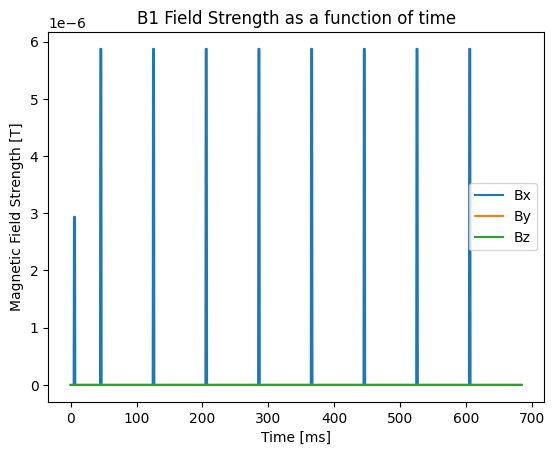

In [33]:
# Create a B1 Array 
B1, T = fse_pulsetrain(PW, ETL, TE, dt, start_pad=start_pad)

# Create a time vector for plotting
ntime = B1.shape[0]
time = np.arange(ntime) * dt

# Plot it as a sanity check
plt.plot(time[::dsamp], B1[::dsamp, 0], label="Bx")
plt.plot(time[::dsamp], B1[::dsamp, 1], label="By")
plt.plot(time[::dsamp], B1[::dsamp, 2], label="Bz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetic Field Strength [T]")
plt.title("B1 Field Strength as a function of time")
plt.legend()
plt.show()

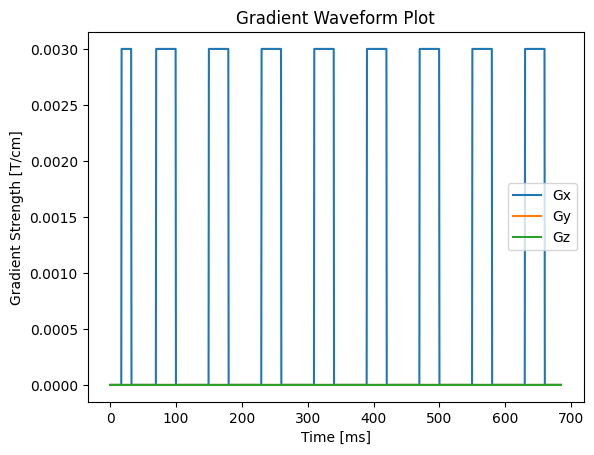

In [34]:
# Create a Gradient Waveform Array
#   We can choose the frequency encoding gradient in any direction, for the purposes 
#   of thissimulation, it doesn't matter, so we choose the x direction.
G, T_G = fse_freq_enc_grad(G_amp, G_dur, ETL, TE, dt, start_pad=start_pad, dim=fenc_dim)

# Make sure the gradient waveform durration is the same as B1 waveform durration
assert(T == T_G)

# Plot G as a sanity check
plt.plot(time[::dsamp], G[::dsamp, 0], label="Gx")
plt.plot(time[::dsamp], G[::dsamp, 1], label="Gy")
plt.plot(time[::dsamp], G[::dsamp, 2], label="Gz")
plt.xlabel("Time [ms]")
plt.ylabel("Gradient Strength [T/cm]")
plt.title("Gradient Waveform Plot")
plt.legend()
plt.show()


In [35]:
# Create Isochrmat positions
iso_pos = np.zeros((3, num_iso))
iso_pos[fenc_dim, :] = np.linspace(-vox_x / 2, vox_x / 2, num_iso)

# Create a 3-array of Effective B fields with the following dimensions:
#       B_eff.shape = (N, D, I)
# Where:
#       N is the number of timepoints to be simulated (same as the variable ntime)
#       D is the number of spatial dimensions (always 3)
#       I is the number of isochromats to be simulated (same as the variable num_iso)
# We use the formula:
#       B_eff = B1 + (G * r)
B_eff = np.zeros((ntime, 3, num_iso))
# B_eff = np.tile(B1.reshape(B1.shape + (1,)), (1, 1, num_iso))           # Repeat B1 for each isochromat
# B_eff[:, 2, :] += np.sum(G[:, :, None] * iso_pos[None, :, :], axis=1)   # We add the Field of the gradient at each isochromat location
B_eff += B1[:, :, None]
B_eff[:, 2, :] += np.sum(G[:, :, None] * iso_pos[None, :, :], axis=1)


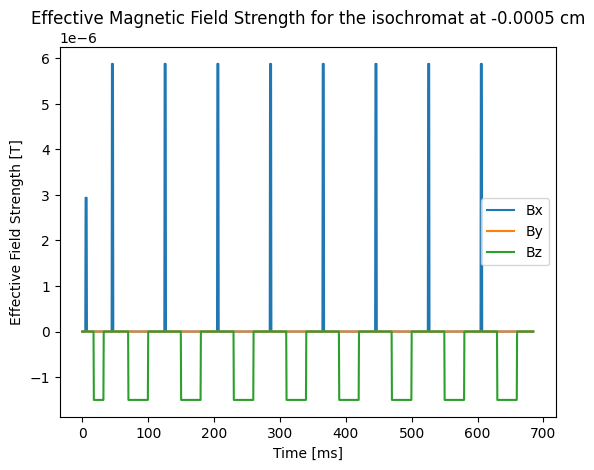

In [36]:
# We can plot the B_eff signal for a particular isochromat as a sanity check. As we change plot_iso_ind, we should see the signal change
plot_iso_ind = 0

plt.plot(time[::dsamp], B_eff[::dsamp, 0, plot_iso_ind], label="Bx")
plt.plot(time[::dsamp], B_eff[::dsamp, 1, plot_iso_ind], label="By")
plt.plot(time[::dsamp], B_eff[::dsamp, 2, plot_iso_ind], label="Bz")
plt.xlabel("Time [ms]")
plt.ylabel("Effective Field Strength [T]")
plt.title(f"Effective Magnetic Field Strength for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm")
plt.legend()
plt.show()

### 2.1 Brain Imaging

In [37]:
# Let's compare Lesioned White Matter Vs Healthy White Matter

# Parameter Values
# Healthy
T1_hlth = 850
T2_hlth = 60
# Lesioned
T1_lsnd = 1400
T2_lsnd = 80
# Cerebral Spinal Fluid (CSF)
T1_csf = 4000
T2_csf = 2000
# Test Impact of T2 Alone
T1_tst = 850
T2_tst = 2000

# Initialize outputs for both cases
M_hlth = np.zeros((ntime, 3, num_iso))
M_lsnd = np.zeros((ntime, 3, num_iso))
M_csf = np.zeros((ntime, 3, num_iso))
M_tst = np.zeros((ntime, 3, num_iso))

# Simulate
for i in range(num_iso):
    M_hlth[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_hlth, T2_hlth, dt)
    M_lsnd[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_lsnd, T2_lsnd, dt)
    M_csf[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_csf, T2_csf, dt)
    M_tst[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_tst, T2_tst, dt)

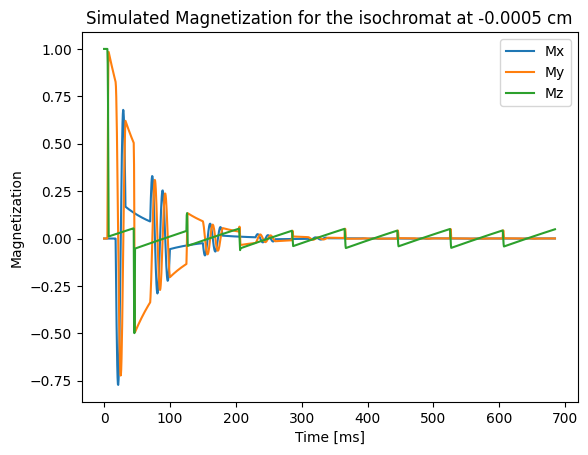

In [38]:
# For a sanity check, let's plot the simulated M(t) for one isochromat
plot_iso_ind = 0

plt.plot(time[::dsamp], M_hlth[::dsamp, 0, plot_iso_ind], label="Mx")
plt.plot(time[::dsamp], M_hlth[::dsamp, 1, plot_iso_ind], label="My")
plt.plot(time[::dsamp], M_hlth[::dsamp, 2, plot_iso_ind], label="Mz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetization")
plt.title(f"Simulated Magnetization for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm")
plt.legend()
plt.show()

In [39]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_hlth, PLOT_PATH + "2_1_Healthy_WM_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_lsnd, PLOT_PATH + "2_1_Lesioned_WM_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_csf, PLOT_PATH + "2_1_CSF_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_tst, PLOT_PATH + "2_1_T2_test_individual_isochromats.mp4", dsamp=dsamp)

In [40]:
# We can now construct the total magnetization by taking the superposition of all isochromats in each voxel
M_hlth_tot = np.mean(M_hlth, axis=2)
M_lsnd_tot = np.mean(M_lsnd, axis=2)
M_csf_tot = np.mean(M_csf, axis=2)

# We also can find the received signal, which will be the l2 norm of the transverse magnetization at each timepoint
S_hlth = np.linalg.norm(M_hlth_tot[:, 0:2], axis=1)
S_lsnd = np.linalg.norm(M_lsnd_tot[:, 0:2], axis=1)
S_csf = np.linalg.norm(M_csf_tot[:, 0:2], axis=1)
# Samity Check
print(M_hlth_tot.shape)
print(S_hlth.shape)

(68500, 3)
(68500,)


In [41]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_hlth_tot, PLOT_PATH + "2_1_Healthy_WM_M_total.mp4", dsamp=dsamp)
    plot_iso_3D(M_lsnd_tot, PLOT_PATH + "2_1_Lesioned_WM_M_total.mp4", dsamp=dsamp)
    plot_iso_3D(M_csf_tot, PLOT_PATH + "2_1_CSF_M_total.mp4", dsamp=dsamp)

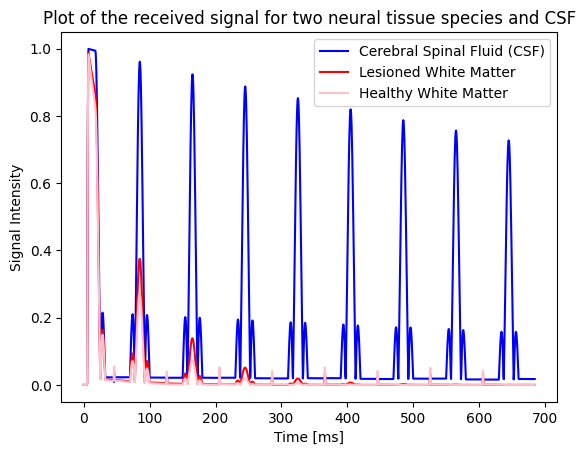

In [42]:
# Now we can make a plot showing the difference in signal intensity for the two cases to display their difference
plt.plot(time[::dsamp], S_csf[::dsamp], label="Cerebral Spinal Fluid (CSF)", color ='blue')
plt.plot(time[::dsamp], S_lsnd[::dsamp], label="Lesioned White Matter",color='red')
plt.plot(time[::dsamp], S_hlth[::dsamp], label="Healthy White Matter", color = 'pink')

plt.xlabel("Time [ms]")
plt.ylabel("Signal Intensity")
plt.title("Plot of the received signal for two neural tissue species and CSF")
plt.legend()
plt.show()

### 2.2 Spinal Cord Imaging

In [43]:
# Let's compare Spinal cords, normal discs, and vetebral body parameters

# Parameter Values
# Spinal Cord
T1_sc = 780
T2_sc = 101
# Normal Disk
T1_nd = 1164
T2_nd = 101
# Vertebral Body
T1_vb = 515
T2_vb = 100
# Illustrative case ()
T1_il = 200
T2_il = 100

# Initialize outputs for both cases
M_sc = np.zeros((ntime, 3, num_iso))
M_nd = np.zeros((ntime, 3, num_iso))
M_vb = np.zeros((ntime, 3, num_iso))
M_il = np.zeros((ntime, 3, num_iso))

# Simulate
for i in range(num_iso):
    M_sc[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_sc, T2_sc, dt)
    M_nd[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_nd, T2_nd, dt)
    M_vb[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_vb, T2_vb, dt)
    M_il[:, :, i] = blochsim_rk4(B_eff[:, :, i].copy(), T1_il, T2_il, dt)

In [44]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_sc, PLOT_PATH + "2_2_Spinal_Cord_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_nd, PLOT_PATH + "2_2_Normal_Disk_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_vb, PLOT_PATH + "2_2_Vertebral_Body_individual_isochromats.mp4", dsamp=dsamp)

In [45]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_sc, PLOT_PATH + "2_2_Spinal_Cord_individual_isochromats_yz_view.mp4", dsamp=dsamp, yz_view=True)
    plot_iso_3D(M_nd, PLOT_PATH + "2_2_Normal_Disk_individual_isochromats_yz_view.mp4", dsamp=dsamp, yz_view=True)
    plot_iso_3D(M_vb, PLOT_PATH + "2_2_Vertebral_Body_individual_isochromats_yz_view.mp4", dsamp=dsamp, yz_view=True)
    plot_iso_3D(M_il, PLOT_PATH + "2_2_Illustrative_Ex_individual_isochromats_yz_view.mp4", dsamp=dsamp, yz_view=True)
    

In [46]:
# We can now construct the total magnetization by taking the superposition of all isochromats in each voxel
M_sc_tot = np.mean(M_sc, axis=2)
M_nd_tot = np.mean(M_nd, axis=2)
M_vb_tot = np.mean(M_vb, axis=2)

# We also can find the received signal, which will be the l2 norm of the transverse magnetization at each timepoint
S_sc = np.linalg.norm(M_sc_tot[:, 0:2], axis=1)
S_nd = np.linalg.norm(M_nd_tot[:, 0:2], axis=1)
S_vb = np.linalg.norm(M_vb_tot[:, 0:2], axis=1)
# Samity Check
print(M_sc_tot.shape)
print(S_sc.shape)

(68500, 3)
(68500,)


In [47]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_sc_tot, PLOT_PATH + "2_2_Spinal_Cord_M_total.mp4", dsamp=dsamp)
    plot_iso_3D(M_nd_tot, PLOT_PATH + "2_2_Normal_Disk_M_total.mp4", dsamp=dsamp)
    plot_iso_3D(M_vb_tot, PLOT_PATH + "2_2_Vertebral_Body_M_total.mp4", dsamp=dsamp)

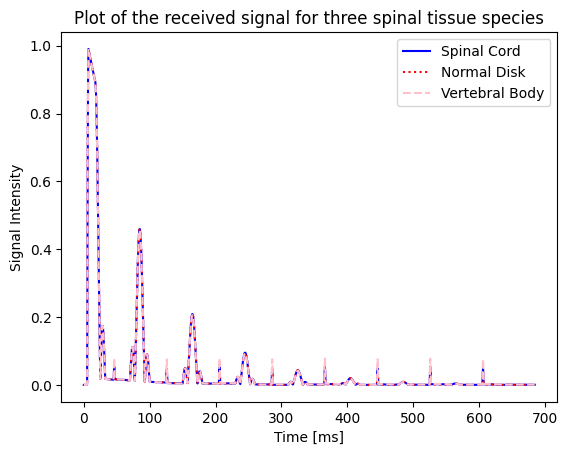

In [48]:
# Now we can make a plot showing the difference in signal intensity for the two cases to display their difference
plt.plot(time[::dsamp], S_sc[::dsamp], label="Spinal Cord", color ='blue', linestyle='solid')
plt.plot(time[::dsamp], S_nd[::dsamp], label="Normal Disk",color='red', linestyle='dotted')
plt.plot(time[::dsamp], S_vb[::dsamp], label="Vertebral Body", color = 'pink', linestyle='dashed')

plt.xlabel("Time [ms]")
plt.ylabel("Signal Intensity")
plt.title("Plot of the received signal for three spinal tissue species")
plt.legend()
plt.show()

#For 1 echo train, no T1 sensitivity bc only one excitation pulse.

### Heart Imaging

In this section of the paper, we will explore the effects of offresonance on the evolution of magnetization inside cardiac voxels for two different tizzue species. We must recompute the `B_eff` array for this simulation using the pulse sequence parameters found in the paper.

In [49]:
# Updated Sequence Parameters
TE = 90             # Echo Time [ms]
ETL = 40            # Echo Train Length
PW = 2              # Width of Excitation and Refocuser Pulses [ms]
G_dur = 30          # Frequency Encoding Gradient Durration [ms]
G_amp = 0.0015      # Frequency Encoding Gradient Amplitude [T/cm]
start_pad = 5       # Dead time at the beginning of sequence [ms]
dt = 0.01           # Simulation Timestep [ms]

offres = 10**-7

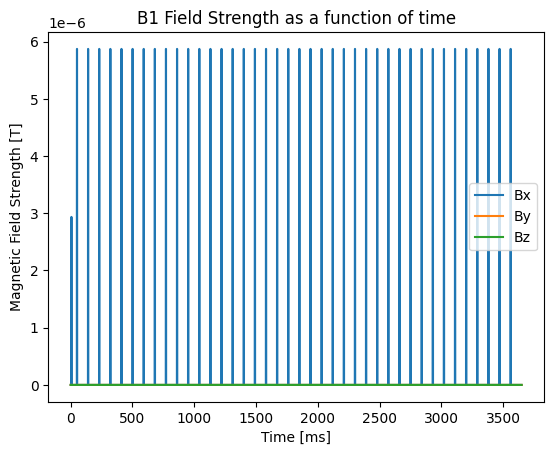

In [50]:
# Create a B1 Array 
B1, T = fse_pulsetrain(PW, ETL, TE, dt, start_pad=start_pad)

# Create a time vector for plotting
ntime = B1.shape[0]
time = np.arange(ntime) * dt

# Plot it as a sanity check
plt.plot(time[::dsamp], B1[::dsamp, 0], label="Bx")
plt.plot(time[::dsamp], B1[::dsamp, 1], label="By")
plt.plot(time[::dsamp], B1[::dsamp, 2], label="Bz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetic Field Strength [T]")
plt.title("B1 Field Strength as a function of time")
plt.legend()
plt.show()

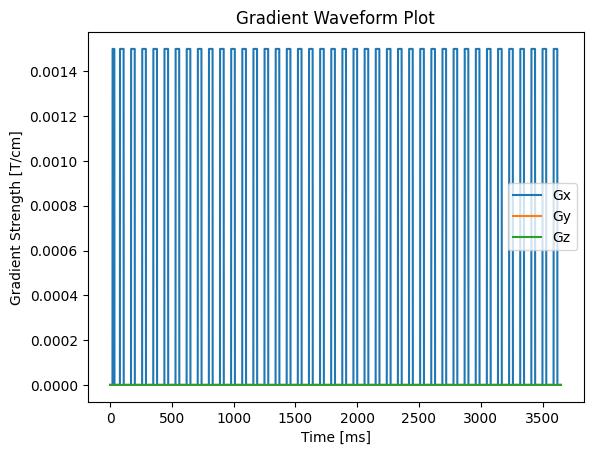

In [51]:
# Create a Gradient Waveform Array
#   We can choose the frequency encoding gradient in any direction, for the purposes 
#   of thissimulation, it doesn't matter, so we choose the x direction.
G, T_G = fse_freq_enc_grad(G_amp, G_dur, ETL, TE, dt, start_pad=start_pad, dim=fenc_dim)

# Make sure the gradient waveform durration is the same as B1 waveform durration
assert(T == T_G)

# Plot G as a sanity check
plt.plot(time[::dsamp], G[::dsamp, 0], label="Gx")
plt.plot(time[::dsamp], G[::dsamp, 1], label="Gy")
plt.plot(time[::dsamp], G[::dsamp, 2], label="Gz")
plt.xlabel("Time [ms]")
plt.ylabel("Gradient Strength [T/cm]")
plt.title("Gradient Waveform Plot")
plt.legend()
plt.show()


In [52]:
# Create a 3-array of Effective B fields with the following dimensions:
#       B_eff.shape = (N, D, I)
# Where:
#       N is the number of timepoints to be simulated (same as the variable ntime)
#       D is the number of spatial dimensions (always 3)
#       I is the number of isochromats to be simulated (same as the variable num_iso)
# We use the formula:
#       B_eff = B1 + (G * r)
B_eff = np.zeros((ntime, 3, num_iso))
# B_eff = np.tile(B1.reshape(B1.shape + (1,)), (1, 1, num_iso))           # Repeat B1 for each isochromat
# B_eff[:, 2, :] += np.sum(G[:, :, None] * iso_pos[None, :, :], axis=1)   # We add the Field of the gradient at each isochromat location
B_eff += B1[:, :, None]
B_eff[:, 2, :] += np.sum(G[:, :, None] * iso_pos[None, :, :], axis=1)

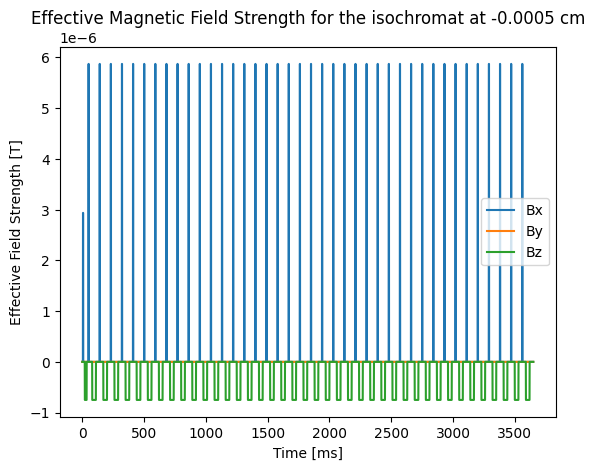

In [53]:
# We can plot the B_eff signal for a particular isochromat as a sanity check. As we change plot_iso_ind, we should see the signal change
plot_iso_ind = 0

plt.plot(time[::dsamp], B_eff[::dsamp, 0, plot_iso_ind], label="Bx")
plt.plot(time[::dsamp], B_eff[::dsamp, 1, plot_iso_ind], label="By")
plt.plot(time[::dsamp], B_eff[::dsamp, 2, plot_iso_ind], label="Bz")
plt.xlabel("Time [ms]")
plt.ylabel("Effective Field Strength [T]")
plt.title(f"Effective Magnetic Field Strength for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm")
plt.legend()
plt.show()

In [54]:
# Let's compare Lesioned White Matter Vs Healthy White Matter

# Parameter Values
# Healthy
T1_hlth = 950
T2_hlth = 55
# Lesioned
T1_amld = 1230
T2_amld = 56

# Initialize outputs for both cases
M_hlth_noff = np.zeros((ntime, 3, num_iso))
M_amld_noff = np.zeros((ntime, 3, num_iso))
M_hlth_woff = np.zeros((ntime, 3, num_iso))
M_amld_woff = np.zeros((ntime, 3, num_iso))

# Simulate
for i in range(num_iso):
    B_eff_iso = B_eff[:, :, i].copy()
    M_hlth_noff[:, :, i] = blochsim_rk4(B_eff_iso, T1_hlth, T2_hlth, dt)
    M_amld_noff[:, :, i] = blochsim_rk4(B_eff_iso, T1_amld, T2_amld, dt)

    B_eff_iso[:, 2] += offres
    M_hlth_woff[:, :, i] = blochsim_rk4(B_eff_iso, T1_hlth, T2_hlth, dt)
    M_amld_woff[:, :, i] = blochsim_rk4(B_eff_iso, T1_amld, T2_amld, dt)

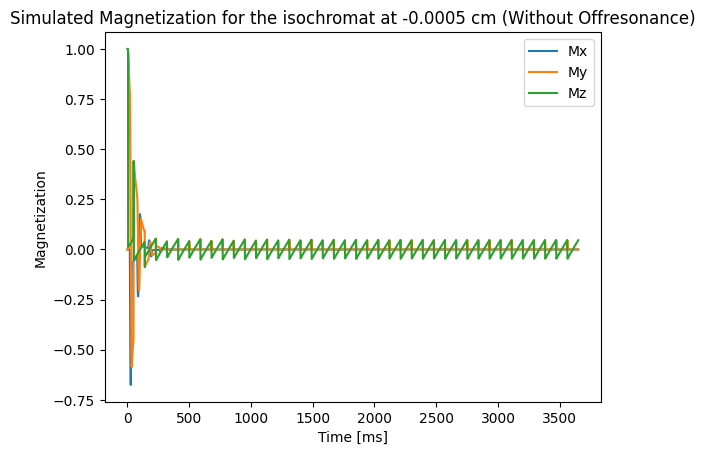

In [55]:
# For a sanity check, let's plot the simulated M(t) for one isochromat (Without Offresonance)
plot_iso_ind = 0

plt.plot(time[::dsamp], M_hlth_noff[::dsamp, 0, plot_iso_ind], label="Mx")
plt.plot(time[::dsamp], M_hlth_noff[::dsamp, 1, plot_iso_ind], label="My")
plt.plot(time[::dsamp], M_hlth_noff[::dsamp, 2, plot_iso_ind], label="Mz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetization")
plt.title(f"Simulated Magnetization for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm (Without Offresonance)")
plt.legend()
plt.show()

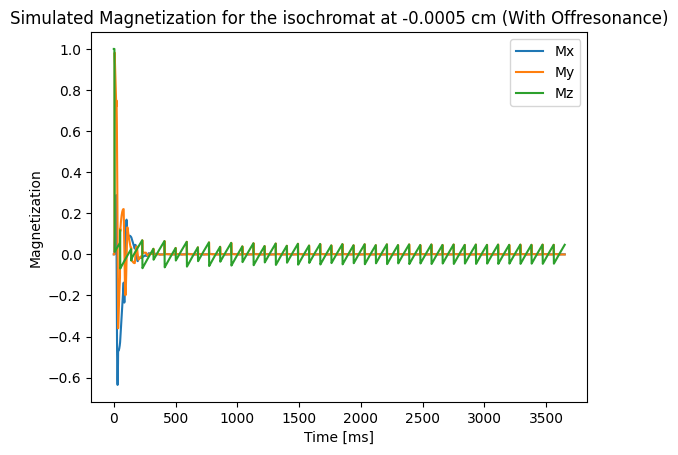

In [56]:
# For a sanity check, let's plot the simulated M(t) for one isochromat (With Offresonance)
plot_iso_ind = 0

plt.plot(time[::dsamp], M_hlth_woff[::dsamp, 0, plot_iso_ind], label="Mx")
plt.plot(time[::dsamp], M_hlth_woff[::dsamp, 1, plot_iso_ind], label="My")
plt.plot(time[::dsamp], M_hlth_woff[::dsamp, 2, plot_iso_ind], label="Mz")
plt.xlabel("Time [ms]")
plt.ylabel("Magnetization")
plt.title(f"Simulated Magnetization for the isochromat at {iso_pos[fenc_dim, plot_iso_ind]:.3} cm (With Offresonance)")
plt.legend()
plt.show()

In [57]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_hlth_noff, PLOT_PATH + "2_3_Healthy_MC_with_offresonance_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_amld_noff, PLOT_PATH + "2_3_Amyloidosis_with_offresonance_individual_isochromats.mp4", dsamp=dsamp)

    plot_iso_3D(M_hlth_noff, PLOT_PATH + "2_3_Healthy_MC_without_offresonance_individual_isochromats.mp4", dsamp=dsamp)
    plot_iso_3D(M_amld_noff, PLOT_PATH + "2_3_Amyloidosis_without_offresonance_individual_isochromats.mp4", dsamp=dsamp)

In [58]:
# We can now construct the total magnetization by taking the superposition of all isochromats in each voxel
M_hlth_noff_tot = np.mean(M_hlth_noff, axis=2)
M_amld_noff_tot = np.mean(M_amld_noff, axis=2)
M_hlth_woff_tot = np.mean(M_hlth_woff, axis=2)
M_amld_woff_tot = np.mean(M_amld_woff, axis=2)

# We also can find the received signal, which will be the l2 norm of the transverse magnetization at each timepoint
S_hlth_noff = np.linalg.norm(M_hlth_noff_tot[:, 0:2], axis=1)
S_amld_noff = np.linalg.norm(M_amld_noff_tot[:, 0:2], axis=1)
S_hlth_woff = np.linalg.norm(M_hlth_woff_tot[:, 0:2], axis=1)
S_amld_woff = np.linalg.norm(M_amld_woff_tot[:, 0:2], axis=1)

# Samity Check
print(M_hlth_noff_tot.shape)
print(S_hlth_noff.shape)

(365000, 3)
(365000,)


In [59]:
# We can now create and save animations of the simulations for individual isochromats
# This might take a minute...
#
# Animations tend not to work inside of jupyter notebooks, if you wish to view the animation, 
# it is saved in the path specified in the second argument of the call to plot_iso_3D().
if save_plots:
    plot_iso_3D(M_hlth_noff_tot, PLOT_PATH + "2_3_Healthy_MC_with_offresonanc_M_total.mp4", dsamp=dsamp)
    plot_iso_3D(M_amld_noff_tot, PLOT_PATH + "2_3_Amyloidosis_with_offresonance_M_total.mp4", dsamp=dsamp)

    plot_iso_3D(M_hlth_woff_tot, PLOT_PATH + "2_3_Healthy_MC_without_offresonanc_M_total.mp4", dsamp=dsamp)
    plot_iso_3D(M_amld_woff_tot, PLOT_PATH + "2_3_Amyloidosis_without_offresonance_M_total.mp4", dsamp=dsamp)

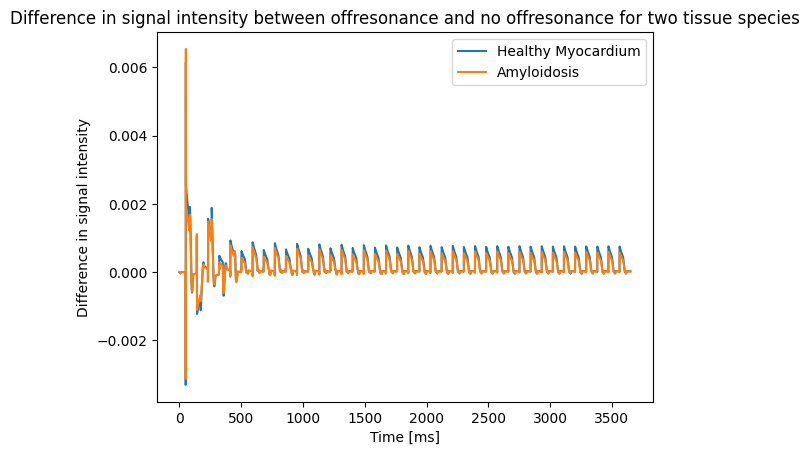

In [60]:
# We can also look at the subtrasctions of the signals to see the difference between with and without offresonance
S_hlth_sub = S_hlth_woff - S_hlth_noff
S_amld_sub = S_amld_woff - S_amld_noff

plt.plot(time[::dsamp], S_hlth_sub[::dsamp], label="Healthy Myocardium")
plt.plot(time[::dsamp], S_amld_sub[::dsamp], label="Amyloidosis")
plt.xlabel("Time [ms]")
plt.ylabel("Difference in signal intensity")
plt.title("Difference in signal intensity between offresonance and no offresonance for two tissue species")
plt.legend()
plt.show()